In [1]:
import numpy as np
import pandas as pd
import os
import pandas_profiling

In [2]:
os.listdir('./data')

['log_doll_drug_consume.csv',
 'log_doll_summary_YM.csv',
 'log_doll_summary_YMD.csv',
 'log_emergency_push.csv',
 'scc_agency.csv',
 'scc_doll.csv',
 'scc_doll_option.csv',
 'scc_ear_function_log.csv',
 'scc_emergency_call.csv',
 'scc_user.csv',
 'scc_user_doll_group.csv',
 'survey_preprocessed.csv']

In [3]:
data_path = './data/'

agency = pd.read_csv(data_path+'scc_agency.csv')
doll = pd.read_csv(data_path+'scc_doll.csv', sep = ';')
doll_option = pd.read_csv(data_path+'scc_doll_option.csv',sep = ';')
user = pd.read_csv(data_path+'scc_user.csv',sep = ';')
user_doll_group = pd.read_csv(data_path+'scc_user_doll_group.csv',sep = ';')

ear_function_log = pd.read_csv(data_path+'scc_ear_function_log.csv',sep = ';')
emergency_call = pd.read_csv(data_path+'scc_emergency_call.csv',sep = ';')

log_doll_drug_consume = pd.read_csv(data_path+'log_doll_drug_consume.csv',sep = ';')
log_doll_summary_YM = pd.read_csv(data_path+'log_doll_summary_YM.csv',sep = ';')
log_doll_summary_YMD = pd.read_csv(data_path+'log_doll_summary_YMD.csv',sep = ';')
log_emergency_push = pd.read_csv(data_path+'log_emergency_push.csv',sep = ';')

## 목표: user  -  user_doll_group  -  agency  -  doll 전처리 / 통합

In [4]:
print(user.columns)    # 앱 사용자: 관리사계정
print(user_doll_group.columns)
print(agency.columns)  # 
print(doll.columns)

Index(['user_id', 'is_resign', 'agency_code', 'alarm_emergency',
       'alarm_emergency_call', 'alarm_low_battery', 'alarm_disconnect'],
      dtype='object')
Index(['group_id', 'agency_code', 'doll_id', 'user_group_member_id', 'is_host',
       'is_agency'],
      dtype='object')
Index(['agency_id', 'agency_name'], dtype='object')
Index(['doll_id', 'user_id', 'battery', 'active_monitor', 'sex', 'birthday',
       'HOUR(wakeup)', 'HOUR(breakfast)', 'HOUR(lunch)', 'HOUR(dinner)',
       'HOUR(sleep)', 'ventilation_walk', 'is_edited', 'drug1', 'drug2',
       'drug3', 'drug4', 'drug5', 'drug6', 'drug7', 'regsted_year',
       'regsted_month', 'mac_id', 'disease1', 'disease2', 'disease3'],
      dtype='object')


In [5]:
print( doll.nunique(), '\n')
print( user.nunique(), '\n')
print( user_doll_group.nunique(), '\n')

doll_id             12496
user_id               979
battery                74
active_monitor         45
sex                     3
birthday               81
HOUR(wakeup)           22
HOUR(breakfast)        22
HOUR(lunch)            22
HOUR(dinner)           24
HOUR(sleep)            24
ventilation_walk        4
is_edited               2
drug1                   2
drug2                   2
drug3                   2
drug4                   2
drug5                   2
drug6                   2
drug7                   2
regsted_year            4
regsted_month          12
mac_id               4428
disease1                2
disease2                2
disease3                2
dtype: int64 

user_id                 2132
is_resign                  2
agency_code              150
alarm_emergency            2
alarm_emergency_call       2
alarm_low_battery          2
alarm_disconnect           1
dtype: int64 

group_id                9878
agency_code              124
doll_id                 8067
user

### 전처리 순서:
1. user_doll_group 에 대해 user의 doll_id 키값으로 user_id 추가
2. user_doll_group 과 user 의 agency 매칭시키기
3. doll 에 나머지 통합 (user, user_group, agnecy)

In [6]:
# row 2088 ; userID 2088 개
user = user[~user['agency_code'].isnull().values]
user['agency_code'] = user['agency_code'].apply(int)

# 설문 45: scc_agency 에 없는 user 삭제
user = user[ user['agency_code'].apply(lambda x: x not in [3,4,1111, 7, 8, 9, 324, 104211001000, 
                                                             991234123001, 999999901001])]

agency_name_dict = dict(zip(agency['agency_id'], agency['agency_name']))
user['agency_name'] = user['agency_code'].apply(lambda x: agency_name_dict[x] )

In [7]:
# doll 에 없는 애들 제거 
# user_group 에 user id 추가
doll_user_dict = dict(zip( doll['doll_id'],doll['user_id']))
user_doll_group = user_doll_group[~user_doll_group['doll_id'].apply(lambda x: x not in doll_user_dict.keys() )]
user = user[~user['user_id'].apply(lambda x: x not in set(doll_user_dict.values()) )]
user_doll_group['user_id'] = user_doll_group['doll_id'].apply(lambda x: doll_user_dict[x])

### 1. user_id 기준으로 user & user_doll_group  merge 시키기 

In [8]:
user_doll_group.rename(columns= {'agency_code': 'gp_agency_code'}, inplace = True)
merged_ = pd.merge(user, user_doll_group, on = 'user_id')
merged_['gp_agency_name']= merged_.loc[:, 'gp_agency_code'].apply(lambda x: agency_name_dict[x] if x in agency_name_dict.keys() else None )

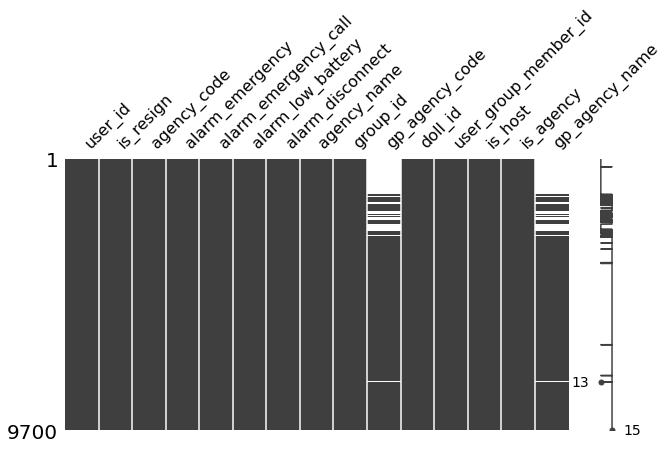

In [9]:
import missingno as msno
%matplotlib inline
msno.matrix(merged_, figsize = (10,5))

In [10]:
non_null = merged_ [ ~merged_.isnull().any(axis=1)]
non_null['gp_agency_code'] = non_null['gp_agency_code'].apply(int)
non_null[ non_null['gp_agency_code'] == non_null['agency_code']  ]

print( non_null[ non_null['agency_code'] == non_null['gp_agency_code']  ].nunique(), '\n')
print(non_null[ non_null['agency_code'] != non_null['gp_agency_code']  ].nunique(), '\n')

user_id                  725
is_resign                  2
agency_code              120
alarm_emergency            2
alarm_emergency_call       2
alarm_low_battery          2
alarm_disconnect           1
agency_name              120
group_id                6730
gp_agency_code           120
doll_id                 5612
user_group_member_id    1174
is_host                    1
is_agency                  2
gp_agency_name           120
dtype: int64 

user_id                  121
is_resign                  2
agency_code               49
alarm_emergency            2
alarm_emergency_call       2
alarm_low_battery          2
alarm_disconnect           1
agency_name               49
group_id                1014
gp_agency_code            25
doll_id                  652
user_group_member_id     242
is_host                    1
is_agency                  2
gp_agency_name            25
dtype: int64 



<ipython-input-10-763cbae9be39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null['gp_agency_code'] = non_null['gp_agency_code'].apply(int)


In [11]:
# 원래뭐였는지 보고 관련성이 있나 확인
set(merged_[merged_['gp_agency_code'].isnull().values]['agency_name'])

{'개인 사용자',
 '광교종합사회복지관',
 '광양시 재가',
 '광양시청',
 '남부노인복지관',
 '별빛마을',
 '아산시노인종합복지관',
 '전체',
 '춘천시개인',
 '춘천시장애인종합복지관',
 '춘천시청',
 '태백노인복지센터',
 '포스코 광양'}

In [12]:
# https://docs.google.com/spreadsheets/d/1z5FgYLsbAmRsQvQuTzCKR_AmJZySmgCuHAL9RKO8Aj0/edit#gid=520402378
gp_null = merged_[merged_['gp_agency_code'].isnull().values]

In [13]:
# 태백노인복지센터 NA 값 2개
tb_1 = merged_[ merged_['agency_name']== '포스코 광양' ]
tb_1[ tb_1.isnull().any(axis = 1) ]
merged_[ merged_['user_group_member_id'] == 7609 ]

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
3707,7609,0,714623007001,0,1,0,0,포스코 광양,5446,7.146230e+11,126799,7609,1,1,포스코 광양
3708,7609,0,714623007001,0,1,0,0,포스코 광양,5453,7.146230e+11,126806,7609,1,1,포스코 광양
3709,7609,0,714623007001,0,1,0,0,포스코 광양,5455,7.146230e+11,126808,7609,1,1,포스코 광양
3710,7609,0,714623007001,0,1,0,0,포스코 광양,5456,7.146230e+11,126809,7609,1,1,포스코 광양
3711,7609,0,714623007001,0,1,0,0,포스코 광양,5457,7.146230e+11,126810,7609,1,1,포스코 광양
3712,7609,0,714623007001,0,1,0,0,포스코 광양,5458,7.146230e+11,126811,7609,1,1,포스코 광양
3713,7609,0,714623007001,0,1,0,0,포스코 광양,5459,7.146230e+11,126812,7609,1,1,포스코 광양
3714,7609,0,714623007001,0,1,0,0,포스코 광양,5461,7.146230e+11,126814,7609,1,1,포스코 광양
3715,7609,0,714623007001,0,1,0,0,포스코 광양,5462,7.146230e+11,126815,7609,1,1,포스코 광양
3716,7609,0,714623007001,0,1,0,0,포스코 광양,5465,7.146230e+11,126818,7609,1,1,포스코 광양


In [14]:
# 태백노인복지센터 NA 값 2개
tb_1 = merged_[ merged_['agency_name']== '태백노인복지센터' ]
tb_1[ tb_1.isnull().any(axis = 1) ]
merged_[ merged_['user_group_member_id'] == 8656 ]

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
7744,8656,0,414219004001,1,1,1,0,태백노인복지센터,3692,0.000000e+00,125496,8656,1,1,전체
7745,8656,0,414219004001,1,1,1,0,태백노인복지센터,3696,NaN,125500,8656,1,1,None
7746,8656,0,414219004001,1,1,1,0,태백노인복지센터,3708,NaN,125512,8656,1,1,None
7747,8656,0,414219004001,1,1,1,0,태백노인복지센터,3738,4.142190e+11,125474,8656,1,1,태백노인복지센터
7748,8656,0,414219004001,1,1,1,0,태백노인복지센터,3741,4.142190e+11,125512,8656,1,1,태백노인복지센터
7749,8656,0,414219004001,1,1,1,0,태백노인복지센터,3772,4.142190e+11,125496,8656,1,1,태백노인복지센터
7750,8656,0,414219004001,1,1,1,0,태백노인복지센터,3773,4.142190e+11,125471,8656,1,1,태백노인복지센터
7751,8656,0,414219004001,1,1,1,0,태백노인복지센터,3775,4.142190e+11,125500,8656,1,1,태백노인복지센터
7752,8656,0,414219004001,1,1,1,0,태백노인복지센터,3780,4.142190e+11,124965,8656,1,1,태백노인복지센터
7753,8656,0,414219004001,1,1,1,0,태백노인복지센터,4200,0.000000e+00,125629,8656,1,1,전체


In [15]:
# 춘천시청 NA 값 10
tb_1 = merged_[ merged_['agency_name']== '춘천시장애인종합복지관' ]
tb_1[ tb_1.isnull().any(axis = 1) ]
merged_[ merged_['user_group_member_id'] == 7512 ] # 7353, 7337,16

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
1952,98,0,14211001002,0,1,0,0,춘천시개인,4153,1.421100e+10,124023,7512,1,1,춘천시청
1953,98,0,14211001002,0,1,0,0,춘천시개인,4161,NaN,125428,7512,1,1,None
1954,98,0,14211001002,0,1,0,0,춘천시개인,4173,NaN,125431,7512,1,1,None
1955,98,0,14211001002,0,1,0,0,춘천시개인,4184,NaN,124017,7512,1,1,None
2015,7195,0,14211001001,1,1,1,0,춘천시장애인종합복지관,4137,1.421100e+10,124258,7512,1,1,춘천시청
2016,7195,0,14211001001,1,1,1,0,춘천시장애인종합복지관,4146,NaN,123945,7512,1,1,None
2017,7195,0,14211001001,1,1,1,0,춘천시장애인종합복지관,4152,NaN,123811,7512,1,1,None
2018,7195,0,14211001001,1,1,1,0,춘천시장애인종합복지관,4174,NaN,123792,7512,1,1,None
2019,7195,0,14211001001,1,1,1,0,춘천시장애인종합복지관,4175,0.000000e+00,123803,7512,1,1,전체
2020,7195,0,14211001001,1,1,1,0,춘천시장애인종합복지관,4188,NaN,123813,7512,1,1,None


In [16]:
# 춘천시청 NA 값 5개
tb_1 = merged_[ merged_['agency_name']== '춘천시개인' ]
tb_1[ tb_1.isnull().any(axis = 1) ] 
#merged_[ merged_['user_group_member_id'] == 7353 ] # 7353, 7512, 16

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
1946,98,0,14211001002,0,1,0,0,춘천시개인,2817,NaN,123765,7353,1,1,None
1947,98,0,14211001002,0,1,0,0,춘천시개인,2825,NaN,123757,7353,1,1,None
1948,98,0,14211001002,0,1,0,0,춘천시개인,2844,NaN,124017,16,1,1,None
1953,98,0,14211001002,0,1,0,0,춘천시개인,4161,NaN,125428,7512,1,1,None
1954,98,0,14211001002,0,1,0,0,춘천시개인,4173,NaN,125431,7512,1,1,None
1955,98,0,14211001002,0,1,0,0,춘천시개인,4184,NaN,124017,7512,1,1,None


In [17]:
# 전체 NA 값 1565 개
tb_1 = merged_[ merged_['agency_name']== '전체' ]
tb_1[ tb_1.isnull().any(axis = 1) ]
#set(tb_1[ tb_1.isnull().any(axis = 1) ]['user_group_member_id'])
#merged_[ merged_['user_group_member_id'] == 7353 ] 

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
0,2,0,0,1,1,1,0,전체,2,NaN,2,2,1,1,None
1,2,0,0,1,1,1,0,전체,3,NaN,3,2,1,1,None
2,2,0,0,1,1,1,0,전체,4,NaN,4,2,1,1,None
3,2,0,0,1,1,1,0,전체,5,NaN,5,2,1,1,None
4,2,0,0,1,1,1,0,전체,6,NaN,6,2,1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586,7369,0,0,1,1,1,0,전체,3001,NaN,125027,7369,1,1,None
2601,7372,0,0,1,1,1,0,전체,2950,NaN,124984,7372,1,1,None
2604,7373,0,0,1,1,1,0,전체,2991,NaN,125020,7373,1,1,None
2605,7373,0,0,1,1,1,0,전체,2992,NaN,125021,7373,1,1,None


In [18]:
# 아산시노인종합복지관 NA 값 21개
tb_1 = merged_[ merged_['agency_name']== '별빛마을']
len(tb_1[ tb_1.isnull().any(axis = 1) ] )
set(tb_1[ tb_1.isnull().any(axis = 1) ]['user_group_member_id'])
merged_[ merged_['user_group_member_id'] == 7433 ] # 16, 7512

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
2055,7202,0,14211001004,1,1,0,0,별빛마을,3505,NaN,125450,7433,1,1,None
2111,7202,0,14211001004,1,1,0,0,별빛마을,5550,NaN,126477,7433,1,1,None


In [19]:
# 남부노인복지관 NA 값 5개
tb_1 = merged_[ merged_['agency_name']== '남부노인복지관' ]
tb_1[ tb_1.isnull().any(axis = 1) ] 
len(tb_1[ tb_1.isnull().any(axis = 1) ] )
merged_[ merged_['user_group_member_id'] == 7429 ] # 7353, 7512, 16

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
1957,8122,0,34420001001,1,1,1,0,아산시노인종합복지관,9326,3.442000e+10,129639,7429,1,1,아산시노인종합복지관
2670,7429,0,1,1,1,1,0,개인 사용자,3472,NaN,125418,7429,1,1,None
2671,7429,0,1,1,1,1,0,개인 사용자,5054,NaN,126449,7429,1,1,None
2672,7429,0,1,1,1,1,0,개인 사용자,5365,NaN,126718,7429,1,1,None
2674,7429,0,1,1,1,1,0,개인 사용자,5714,NaN,127029,7429,1,1,None
2675,7429,0,1,1,1,1,0,개인 사용자,7054,1.000000e+00,128143,7429,1,0,개인 사용자
2676,7429,0,1,1,1,1,0,개인 사용자,7162,1.000000e+00,128240,7429,1,0,개인 사용자
2677,7429,0,1,1,1,1,0,개인 사용자,7210,1.000000e+00,128283,7429,1,0,개인 사용자
2678,7429,0,1,1,1,1,0,개인 사용자,7305,1.000000e+00,128359,7429,1,0,개인 사용자
2679,7429,0,1,1,1,1,0,개인 사용자,7306,1.000000e+00,128360,7429,1,0,개인 사용자


In [20]:
# 광양시청 NA 값 122개
tb_1 = merged_[ merged_['agency_name']== '광양시청' ]
tb_1[ tb_1.isnull().any(axis = 1) ] 
set(tb_1[ tb_1.isnull().any(axis = 1) ]['user_group_member_id'])

{96,
 7384,
 7385,
 7389,
 7392,
 7393,
 7399,
 7400,
 7401,
 7402,
 7406,
 7407,
 7409,
 7410,
 7413,
 7417,
 7420,
 7421,
 7423,
 7425,
 7427,
 7432,
 7436,
 7437,
 7438,
 7439,
 7441,
 7442,
 7445,
 7447,
 7448,
 7453,
 7456,
 7457,
 7460,
 7462,
 7463,
 7464,
 7478,
 7506}

In [21]:
# 광양시 재가 NA 값 4개
tb_1 = merged_[ merged_['agency_name']== '광양시 재가' ]
tb_1[ tb_1.isnull().any(axis = 1) ] 
merged_[ merged_['user_group_member_id'] == 96 ] # 7385, 96, 7389

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
1266,96,0,24623001000,0,1,0,0,광양시청,1114,NaN,912,96,1,1,None
1267,96,0,24623001000,0,1,0,0,광양시청,1886,NaN,124089,96,1,1,None
1268,96,0,24623001000,0,1,0,0,광양시청,2467,NaN,124560,96,1,1,None
1269,96,0,24623001000,0,1,0,0,광양시청,2473,NaN,124566,96,1,1,None
1270,96,0,24623001000,0,1,0,0,광양시청,2567,NaN,124660,96,1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4530,8012,0,212911003001,1,1,1,0,광주동구보건소,8608,2.462300e+10,128527,96,1,1,광양시청
4531,8012,0,212911003001,1,1,1,0,광주동구보건소,8610,2.462300e+10,128521,96,1,1,광양시청
4532,8012,0,212911003001,1,1,1,0,광주동구보건소,8612,2.462300e+10,128878,96,1,1,광양시청
4559,8014,0,1,1,1,1,0,개인 사용자,8609,2.462300e+10,128412,96,1,1,광양시청


In [22]:
# 광양시 재가 NA 값 2개
tb_1 = merged_[ merged_['agency_name']== '광교종합사회복지관' ]
tb_1[ tb_1.isnull().any(axis = 1) ] 
#merged_[ merged_['user_group_member_id'] == 7242 ] 

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
2180,7242,0,434111704002,1,1,0,0,광교종합사회복지관,1915,NaN,124118,7242,1,1,None
2181,7242,0,434111704002,1,1,0,0,광교종합사회복지관,1916,NaN,124119,7242,1,1,None


In [23]:
# 광양시 재가 NA 값 2개
tb_1 = merged_[ merged_['agency_name']== '개인 사용자' ]
tb_1[ tb_1.isnull().any(axis = 1) ] 
#set(tb_1[ tb_1.isnull().any(axis = 1) ]['user_group_member_id'])
#merged_[ merged_['user_group_member_id'] == 7242 ] 

,user_id,is_resign,agency_code,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,agency_name,group_id,gp_agency_code,doll_id,user_group_member_id,is_host,is_agency,gp_agency_name
159,18,0,1,1,1,1,0,개인 사용자,93,NaN,69,18,1,1,None
160,18,0,1,1,1,1,0,개인 사용자,114,NaN,83,18,1,1,None
161,18,0,1,1,1,1,0,개인 사용자,115,NaN,84,18,1,1,None
162,18,0,1,1,1,1,0,개인 사용자,116,NaN,85,18,1,1,None
163,18,0,1,1,1,1,0,개인 사용자,117,NaN,86,18,1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2796,7502,1,1,1,1,1,0,개인 사용자,3824,NaN,125594,7502,1,1,None
2797,7503,1,1,1,1,1,0,개인 사용자,3825,NaN,125595,7503,1,1,None
2798,7504,0,1,1,1,1,0,개인 사용자,3826,NaN,125596,7504,1,1,None
3229,7580,0,1,1,1,1,0,개인 사용자,5618,NaN,126434,7650,1,1,None


### 2. user_group NA 날리고 불일치는 user_group 기준으로 변경, match_agc 추가

In [24]:
non_null['match_agc'] = 1 * (non_null['agency_code'] == non_null['gp_agency_code']  )
non_null.drop(columns = ['agency_code', 'agency_name'], inplace = True)
non_null.rename(columns = {'gp_agency_code': 'agency_code', 'gp_agency_name':'agency_name'}, inplace = True)

<ipython-input-24-1f8de7e54a2b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null['match_agc'] = 1 * (non_null['agency_code'] == non_null['gp_agency_code']  )
C:\Users\NormalKim\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\NormalKim\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [25]:
non_null

,user_id,is_resign,alarm_emergency,alarm_emergency_call,alarm_low_battery,alarm_disconnect,group_id,agency_code,doll_id,user_group_member_id,is_host,is_agency,agency_name,match_agc
295,18,0,1,1,1,0,4230,0,125649,18,1,1,전체,0
296,18,0,1,1,1,0,4315,0,125730,18,1,1,전체,0
297,18,0,1,1,1,0,4316,0,125731,18,1,1,전체,0
298,18,0,1,1,1,0,4927,0,126342,18,1,1,전체,0
299,18,0,1,1,1,0,6172,0,127441,18,1,1,전체,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9695,9181,0,1,1,1,0,15336,1,135027,9216,1,0,개인 사용자,1
9696,9181,0,1,1,1,0,15337,1,135028,9216,1,0,개인 사용자,1
9697,9181,0,1,1,1,0,15338,1,135029,9217,1,0,개인 사용자,1
9698,9215,0,1,1,1,0,15326,1,135023,9215,1,0,개인 사용자,1


## 3. doll 과 나머지 통합

In [26]:
doll_option.drop(columns = 'is_edited', inplace = True)
doll_merged = pd.merge( doll, non_null, on = ['user_id', 'doll_id'])
doll_merged = pd.merge( doll_merged, doll_option, on = 'doll_id' )

In [27]:
doll_merged.to_csv('doll_merged.csv', index = False)

In [28]:
doll_merged.nunique()

doll_id                 6258
user_id                  773
battery                   72
active_monitor            39
sex                        3
birthday                  68
HOUR(wakeup)              20
HOUR(breakfast)           20
HOUR(lunch)               19
HOUR(dinner)              24
HOUR(sleep)               24
ventilation_walk           4
is_edited                  2
drug1                      2
drug2                      2
drug3                      2
drug4                      2
drug5                      2
drug6                      2
drug7                      2
regsted_year               4
regsted_month             12
mac_id                  3964
disease1                   2
disease2                   2
disease3                   2
is_resign                  2
alarm_emergency            2
alarm_emergency_call       2
alarm_low_battery          2
alarm_disconnect           1
group_id                7744
agency_code              123
user_group_member_id    1290
is_host       

In [238]:
indi_user = doll_merged[ doll_merged['agency_name'] == '개인 사용자']
indi_counts = indi_user.loc[:, ['user_group_member_id', 'user_id']].value_counts()
indi_unique_one = pd.DataFrame(indi_counts[indi_counts == 1]).reset_index()['user_id'].tolist()
indi_user_unique = indi_user[ indi_user['user_group_member_id'].apply(lambda x: x in indi_unique_gpid) ]
indi_userid_cnt = indi_user_unique['user_id'].value_counts()
indi_userid_one = list(indi_userid_cnt[indi_userid_cnt == 1].index)
indi_user_unique_gpuser = indi_user_unique[ indi_user_unique['user_id'].apply(lambda x: x in indi_userid_one) ]

In [273]:
user_id_cnt = doll_merged['user_id'].value_counts()
one_user = list(user_id_cnt[ user_id_cnt == 1 ].index)

In [287]:
no_agency = doll_merged[ doll_merged['user_id'].apply(lambda x: x in one_user) ].groupby('is_agency').get_group(0)

In [299]:
no_agency[no_agency['mac_id'] == '861760040555697']

,doll_id,user_id,battery,active_monitor,sex,birthday,HOUR(wakeup),HOUR(breakfast),HOUR(lunch),HOUR(dinner),...,relig3,relig4,relig5,religion_alarm,calender_type,is_active_detect,grandFM,honorFM,right_ear_function,left_ear_function
3161,130740,8165,82,24,1,1994,7,8,12,18,...,NaN,NaN,NaN,0,0,0,1,0,0010000,0000100
3162,130741,8166,100,24,1,1940,7,9,11,18,...,NaN,NaN,NaN,0,0,0,1,0,0010010,0001101
4371,131824,8456,100,24,1,1940,7,8,12,18,...,NaN,NaN,NaN,0,0,0,1,0,1111000,0000111
4377,131828,8459,100,24,2,1940,7,8,12,18,...,NaN,NaN,NaN,0,0,0,1,0,0011000,0100110
4423,131859,8479,100,24,1,1934,6,7,12,18,...,NaN,NaN,NaN,0,0,0,1,0,0100001,1010000


In [282]:
doll_merged[ doll_merged['user_id'].apply(lambda x: x in one_user) ].nunique()

doll_id                 388
user_id                 388
battery                  68
active_monitor           23
sex                       2
birthday                 51
HOUR(wakeup)             14
HOUR(breakfast)          15
HOUR(lunch)              13
HOUR(dinner)             14
HOUR(sleep)              16
ventilation_walk          4
is_edited                 2
drug1                     2
drug2                     2
drug3                     2
drug4                     2
drug5                     2
drug6                     2
drug7                     2
regsted_year              4
regsted_month            12
mac_id                  337
disease1                  2
disease2                  2
disease3                  2
is_resign                 2
alarm_emergency           2
alarm_emergency_call      2
alarm_low_battery         2
alarm_disconnect          1
group_id                388
agency_code              14
user_group_member_id    383
is_host                   1
is_agency           

In [270]:
gp_user_id_cnt[ gp_user_id_cnt == 1 ]

user_id  user_group_member_id
8463     8463                    1
8462     8462                    1
8269     8401                    1
         8400                    1
8599     8599                    1
                                ..
8050     8075                    1
8047     8563                    1
         8186                    1
         8185                    1
9215     9215                    1
Length: 1103, dtype: int64

In [29]:
#pr = doll_merged.profile_report()
#pr.to_file('./doll_merged.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]